# DSAI 305 - Project -  Phase 3
> **Notebook for paper:**  "*Explainable Ai-Driven Financial Transaction Fraud Detection Using Machine Learning and Deep Neural Networks*"
>
> https://dx.doi.org/10.2139/ssrn.4439980



by :  `Anas Ahmad Abdelsalam - 202202029`
---
------
-----

`Imports`

In [ ]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

filee = "PS_20174392719_1491204439457_log.csv"
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "ealaxi/paysim1",
  filee,
)

<ipython-input-1-2fa04b40a025>:5: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


In [ ]:
import pandas as pd
import numpy as np
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, accuracy_score,roc_curve, auc,confusion_matrix
import seaborn as sns
import shap
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.inspection import permutation_importance
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import warnings
import tensorflow as tf

# Main

## Preprocessing

### `Generic`

In [ ]:
df.head(2)

step     type   amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1  PAYMENT  9839.64  C1231006815       170136.0       160296.36   
1     1  PAYMENT  1864.28  C1666544295        21249.0        19384.72   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [ ]:
# frequenncy encoding to 'type', like paper used for (product code...)
df['type'].value_counts(normalize=True)
df['type'] = df['type'].map(df['type'].value_counts(normalize=True))

# label encoding to nameOrig and nameDest (like paper used limited object features)
le = LabelEncoder()
df['nameOrig'] = le.fit_transform(df['nameOrig'])
df['nameDest'] = le.fit_transform(df['nameDest'])
df.head(2)

step      type   amount  nameOrig  oldbalanceOrg  newbalanceOrig  nameDest  \
0     1  0.338146  9839.64    757869       170136.0       160296.36   1662094   
1     1  0.338146  1864.28   2188998        21249.0        19384.72   1733924   

   oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0             0.0             0.0        0               0  
1             0.0             0.0        0               0

In [ ]:
# percentage of isFraude
df['isFraud'].value_counts(normalize=True)


''' we can see that the paysim has about 0.001 fraud, while ieee-cs datset int he paper had 3.5% and even with this,
 they user random oversampling'''

' we can see that the paysim has about 0.001 fraud, while ieee-cs datset int he paper had 3.5% and even with this,\n they user random oversampling'

In [ ]:
#
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(df.drop('isFraud', axis=1), df['isFraud'])
df_resampled = pd.concat([pd.DataFrame(X_resampled, columns=df.drop('isFraud', axis=1).columns), pd.DataFrame(y_resampled, columns=['isFraud'])], axis=1)
df_resampled['isFraud'].value_counts(normalize=True)


isFraud
0    0.5
1    0.5
Name: proportion, dtype: float64

In [ ]:
df_resampled.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud',
       'isFraud'],
      dtype='object')

In [ ]:
# paper dropped some redundunt features like id, so the isFlaggedFraud can be considered as thiscome with the main label
# drop the column
df_resampled.drop(['isFlaggedFraud'], axis=1, inplace=True)

`Split`

In [ ]:
X = df_resampled.drop('isFraud', axis=1)
y = df_resampled['isFraud']

In [ ]:
# standardize data
scaler = StandardScaler()
X = scaler.fit_transform(X)

### `CNN special`

In [ ]:
# reshape for the cnn
X.reshape(X.shape[0], X.shape[1], 1)

array([[[-1.57602708],
        [ 0.69544061],
        [-0.43578076],
        ...,
        [ 1.94090164],
        [-0.24303724],
        [-0.32975486]],

       [[-1.57602708],
        [ 0.69544061],
        [-0.44005098],
        ...,
        [ 2.06271444],
        [-0.24303724],
        [-0.32975486]],

       [[-1.57602708],
        [-1.45279155],
        [-0.44095225],
        ...,
        [-0.13211885],
        [-0.24303724],
        [-0.32975486]],

       ...,

       [[ 0.41913451],
        [ 0.80958883],
        [-0.44104917],
        ...,
        [-0.7144003 ],
        [ 2.10956834],
        [ 1.76717167]],

       [[-0.76452353],
        [-1.45279155],
        [-0.34924669],
        ...,
        [-0.12155371],
        [-0.24303724],
        [-0.32975486]],

       [[ 0.24339489],
        [-1.45279155],
        [-0.29376307],
        ...,
        [-0.53688736],
        [-0.24303724],
        [-0.32975486]]])

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # 70 and 30 split like the paper
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((8896169, 9), (3812645, 9), (8896169,), (3812645,))

In [ ]:
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)

-----
## Model

In [ ]:
model = Sequential([

    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(9, 1), padding='same'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy']) ## paper mentioned that the 0.1 Lr is the best
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 9, 32)          │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 4, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 4, 64)          │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,169 (121.75 KB)

 Trainable params: 31,169 (121.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(x_train, y_train,epochs=30,batch_size=1024,validation_split=0.2,callbacks=[early_stopping],verbose=1)

Epoch 1/30
6951/6951 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - accuracy: 0.9408 - loss: 0.1391 - val_accuracy: 0.9811 - val_loss: 0.0519
Epoch 2/30
6951/6951 ━━━━━━━━━━━━━━━━━━━━ 33s 4ms/step - accuracy: 0.9761 - loss: 0.0625 - val_accuracy: 0.9800 - val_loss: 0.0498
Epoch 3/30
6951/6951 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - accuracy: 0.9798 - loss: 0.0534 - val_accuracy: 0.9854 - val_loss: 0.0398
Epoch 4/30
6951/6951 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - accuracy: 0.9820 - loss: 0.0483 - val_accuracy: 0.9869 - val_loss: 0.0357
Epoch 5/30
6951/6951 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - accuracy: 0.9837 - loss: 0.0445 - val_accuracy: 0.9865 - val_loss: 0.0356
Epoch 6/30
6951/6951 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.9850 - loss: 0.0414 - val_accuracy: 0.9882 - val_loss: 0.0314
Epoch 7/30
6951/6951 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.9859 - loss: 0.0393 - val_accuracy: 0.9833 - val_loss: 0.0429
Epoch 8/30
6951/6951 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.9868 - loss: 0

`Training Results`

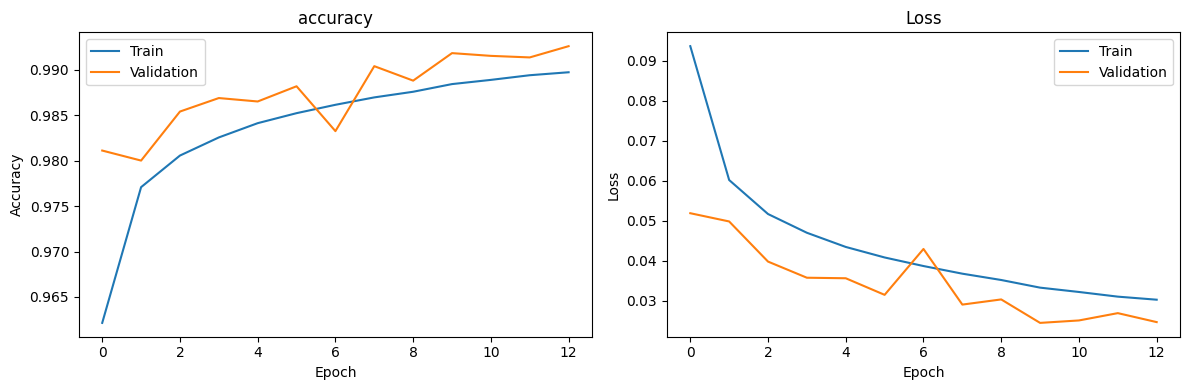

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.0243
Test Accuracy: 0.9919


In [ ]:
y_pred_proba = model.predict(x_test)
y_pred_proba

119146/119146 ━━━━━━━━━━━━━━━━━━━━ 176s 1ms/step


array([[6.4627377e-18],
       [0.0000000e+00],
       [9.9954468e-01],
       ...,
       [0.0000000e+00],
       [3.1524600e-20],
       [9.9997532e-01]], dtype=float32)

In [ ]:
y_pred = (y_pred_proba > 0.5).astype(int)

In [ ]:
# make classification report
rep = classification_report(y_test, y_pred,output_dict=True)
report_df = pd.DataFrame(rep).transpose()
report_df.style.background_gradient(cmap='Blues').format('{:.2f}')

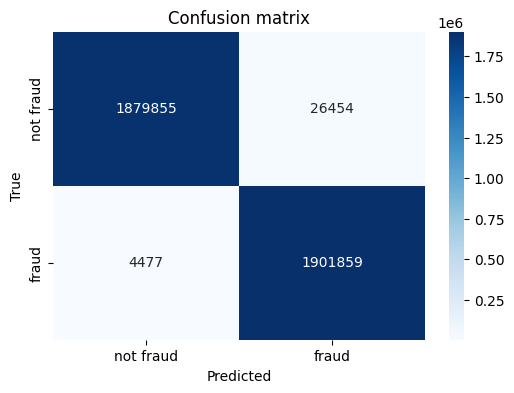

In [ ]:
# Confusuion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['not fraud','fraud'], yticklabels=['not fraud','fraud'])
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

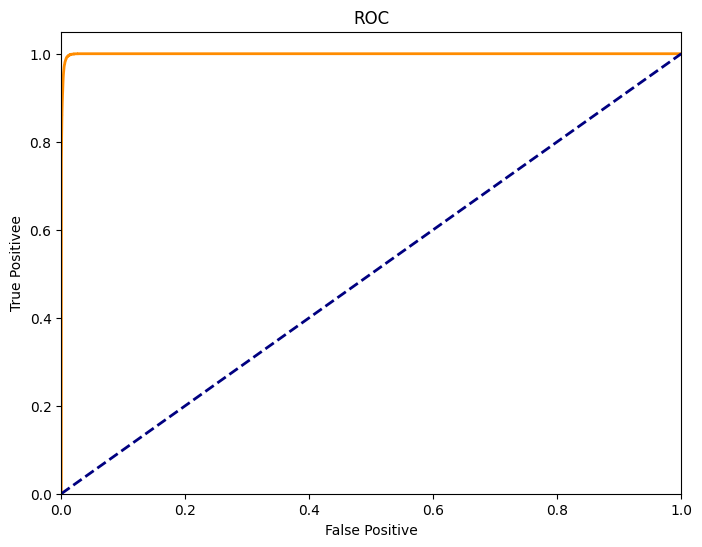

In [ ]:
# roc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive')
plt.ylabel('True Positivee')
plt.title('ROC')
plt.show()

# ---- Explainability -----

### 1. Shap

In [ ]:
# train and test shapes
x_train.shape, x_test.shape

((8896169, 9, 1), (3812645, 9, 1))

In [ ]:
trainSubs = x_train[:100]
trainSubs_flat = trainSubs.squeeze(axis=2)  # (100,9)
print(f"trainSubs_flat shape: {trainSubs_flat.shape}")

trainSubs_flat shape: (100, 9)


In [ ]:
testSubs = x_test[:100]
testSubs_flat = testSubs.squeeze(axis=2)  # (100,9)
print(f"testSubs_flat shape: {testSubs_flat.shape}")

testSubs_flat shape: (100, 9)


In [ ]:

trainSubs_size = 100
if trainSubs_size > x_train.shape[0]:
    trainSubs_size = x_train.shape[0]
background_indices = np.random.choice(x_train.shape[0], trainSubs_size, replace=False)
trainSubs = x_train[background_indices]
trainSubs_flat = trainSubs.squeeze(axis=2)


testSubs_size = 50
if testSubs_size > x_test.shape[0]:
    testSubs_size = x_test.shape[0]
testSubs = x_test[:testSubs_size]
testSubs_flat = testSubs.squeeze(axis=2)


# --- prediction function ---
#
def predict_fn_shap(x):
    # (num_samples, num_features)
    # reshape to predict
    x_reshaped = x.reshape(-1,9,1)
    predictions = model.predict(x_reshaped, batch_size=128, verbose=0)
    if predictions.ndim > 1 and predictions.shape[-1] == 1:
         return predictions.squeeze(axis=-1)
    elif predictions.ndim == 0:
         return predictions.reshape(1,)
    return predictions


explainer = shap.KernelExplainer(predict_fn_shap, trainSubs_flat)
shap_values = explainer.shap_values(testSubs_flat, nsamples='auto')
shap_values.shape

  0%|          | 0/50 [00:00<?, ?it/s]

(50, 9)

#### `Plot`

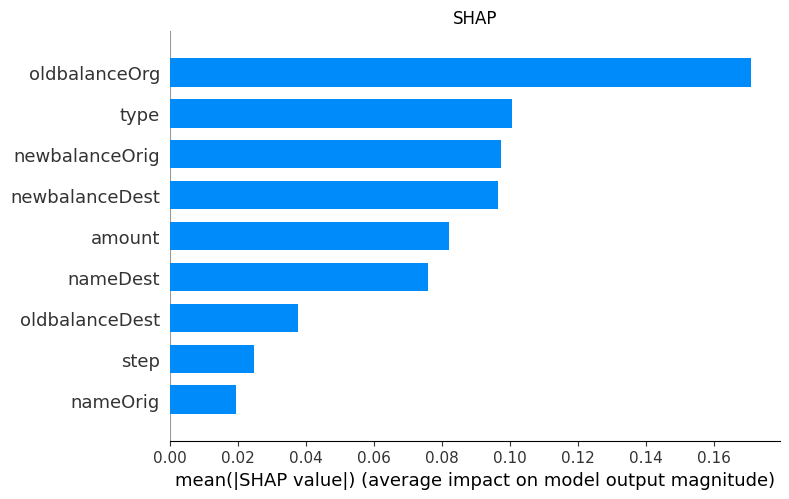

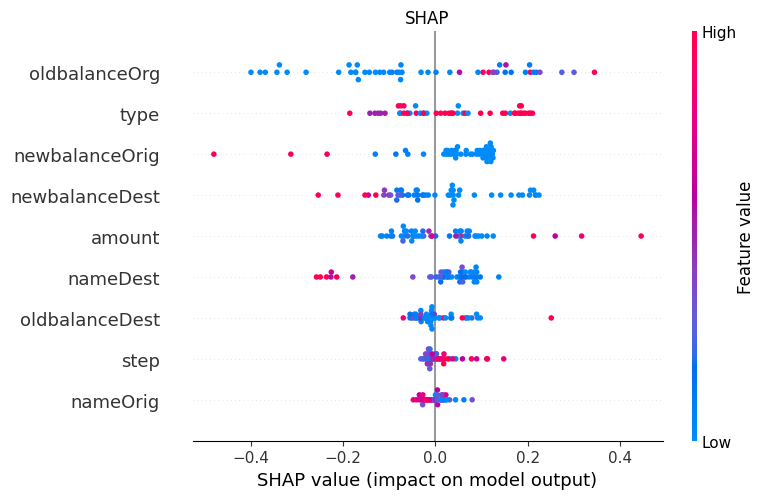

In [ ]:
feature_names = df_resampled.drop('isFraud', axis=1).columns.tolist()
plt.figure()
shap.summary_plot(shap_values, testSubs_flat, feature_names=feature_names, plot_type="bar", show=False)
plt.title('SHAP')
plt.tight_layout()
plt.show()
plt.figure()
shap.summary_plot(shap_values, testSubs_flat, feature_names=feature_names, show=False)
plt.title('SHAP')
plt.tight_layout()
plt.show()

## 2. LIME

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 17.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=f814bf6ba01198d12b74b0cbfa6c7d43fe5c33753100f1fe246bb2d7e5fcaee1
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:

trainSubs_size = 100
testSubs_size = 50

if trainSubs_size > x_train.shape[0]:
    trainSubs_size = x_train.shape[0]
train_indices = np.random.choice(x_train.shape[0], trainSubs_size, replace=False)
trainSubs = x_train[train_indices]
testSubs_flat = trainSubs.squeeze(axis=2)

if testSubs_size > x_test.shape[0]:
    testSubs_size = x_test.shape[0]
test_indices = np.arange(testSubs_size)
testSubs = x_test[test_indices]
testSubs_flat = testSubs.squeeze(axis=2)


if isinstance(y_test, pd.Series):
    y_testSubs = y_test.iloc[test_indices]
else:
    y_testSubs = y_test[test_indices]

print( trainSubs_flat.shape)
print( testSubs_flat.shape)
print( y_testSubs.shape)

(100, 9)
(50, 9)
(50,)


#### `Plot`

In [ ]:
def predictor_lime(data_flat):
    data_reshaped = data_flat.reshape(-1,9,1)
    prob_fraud = model.predict(data_reshaped,batch_size=128,verbose=0)
    prob_not_fraud = 1.0 - prob_fraud
    return np.hstack((prob_not_fraud,prob_fraud))


feature_names = df_resampled.drop('isFraud',axis=1).columns.tolist()

explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=trainSubs_flat,
    feature_names=feature_names,
    class_names=['Not Fraud','Fraud'],
    mode='classification',
    verbose=False,
    random_state=42
)

explains = min(3,testSubs_size)

for i in range(explains):
    instance_to_explain = testSubs_flat[i] # (9,)
    true_label = y_testSubs.iloc[i] if isinstance(y_testSubs, pd.Series) else y_testSubs[i]

    print(f"\nExplaining instance {i} (True label: {true_label})")
    explanation_lime = explainer_lime.explain_instance(
        data_row=instance_to_explain,
        predict_fn=predictor_lime,
        num_features=len(feature_names),
        top_labels=1
    )

    explanation_lime.show_in_notebook(show_table=True, show_all=False)



Explaining instance 0 (True label: 0)



Explaining instance 1 (True label: 0)



Explaining instance 2 (True label: 1)


## 3. Permutation Importance

In [ ]:
''' a wrapper for the cnn classifier (kinda late)'''

testSubs = x_test[:5000]  # (5000,9,1)
y_testSubs = y_test[:5000]  # (5000,)

testSubs_flat = testSubs.squeeze(axis=2)  # (5000,9)

class CNNWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model):
        self.model = model
        self.fitted_ = True
        self._estimator_type = 'classifier'

    def fit(self, X, y=None):
        self.fitted_ = True
        return self

    def predict(self, X):
        X_reshaped = X.reshape(-1, 9, 1)
        predictions = self.model.predict(X_reshaped, batch_size=32, verbose=0)
        return (predictions > 0.5).astype(int).flatten()

    def predict_proba(self, X):
        X_reshaped = X.reshape(-1, 9, 1)
        probabilities = self.model.predict(X_reshaped, batch_size=32, verbose=0)
        return np.column_stack((1 - probabilities, probabilities))

In [ ]:
# call for permutations
cnn_wrapper = CNNWrapper(model)
perm_importance = permutation_importance(
    cnn_wrapper,
    testSubs_flat,
    y_testSubs,
    n_repeats=10,
    random_state=42,
    scoring='accuracy',
    n_jobs=-1
)

#### `Plot`

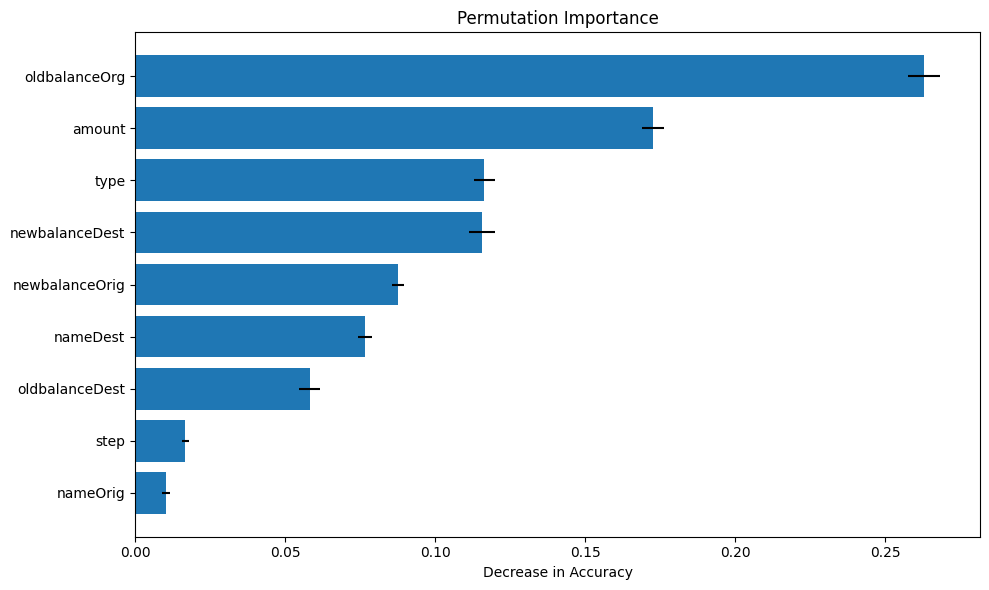

In [ ]:
mean_importance = perm_importance.importances_mean
std_importance = perm_importance.importances_std
sorted_idx = mean_importance.argsort()
sorted_features = np.array(feature_names)[sorted_idx]
sorted_mean = mean_importance[sorted_idx]
sorted_std = std_importance[sorted_idx]
plt.figure(figsize=(10,6))
plt.barh(sorted_features, sorted_mean, xerr=sorted_std)
plt.xlabel('Decrease in Accuracy')
plt.title('Permutation Importance')
plt.tight_layout()
plt.show()

## 4. Integrated Gradients

In [ ]:
# get gradient
def compute_gradients(model, inputs, target_class_index):
    with tf.GradientTape() as tape:
        tape.watch(inputs)
        outputs = model(inputs, training=False)[:, 0]
        out = outputs if target_class_index == 1 else (1.0-outputs)
    grads = tape.gradient(out,inputs)
    return grads

def integrated_gradients(model, baseline, sample, target_class_index=1, m_steps=50):
    baseline = tf.cast(baseline.reshape(1, -1, 1), tf.float32)
    sample = tf.cast(sample.reshape(1, -1, 1), tf.float32)
    # Linear interpolation between baseline and input
    alphas = tf.linspace(0.0, 1.0, m_steps + 1)[:, tf.newaxis, tf.newaxis, tf.newaxis]
    interpolated = baseline + alphas * (sample - baseline)
    interpolated = tf.reshape(interpolated, (-1, sample.shape[1], 1))
    # Compute gradients for all steps at once
    grads = compute_gradients(model, interpolated, target_class_index)
    grads = tf.reshape(grads, (m_steps + 1, sample.shape[1], 1))
    # Average gradients & scale by input-baseline
    avg_grads = tf.reduce_mean(grads, axis=0).numpy().flatten()
    ig = (sample.numpy().flatten() - baseline.numpy().flatten()) * avg_grads
    return ig


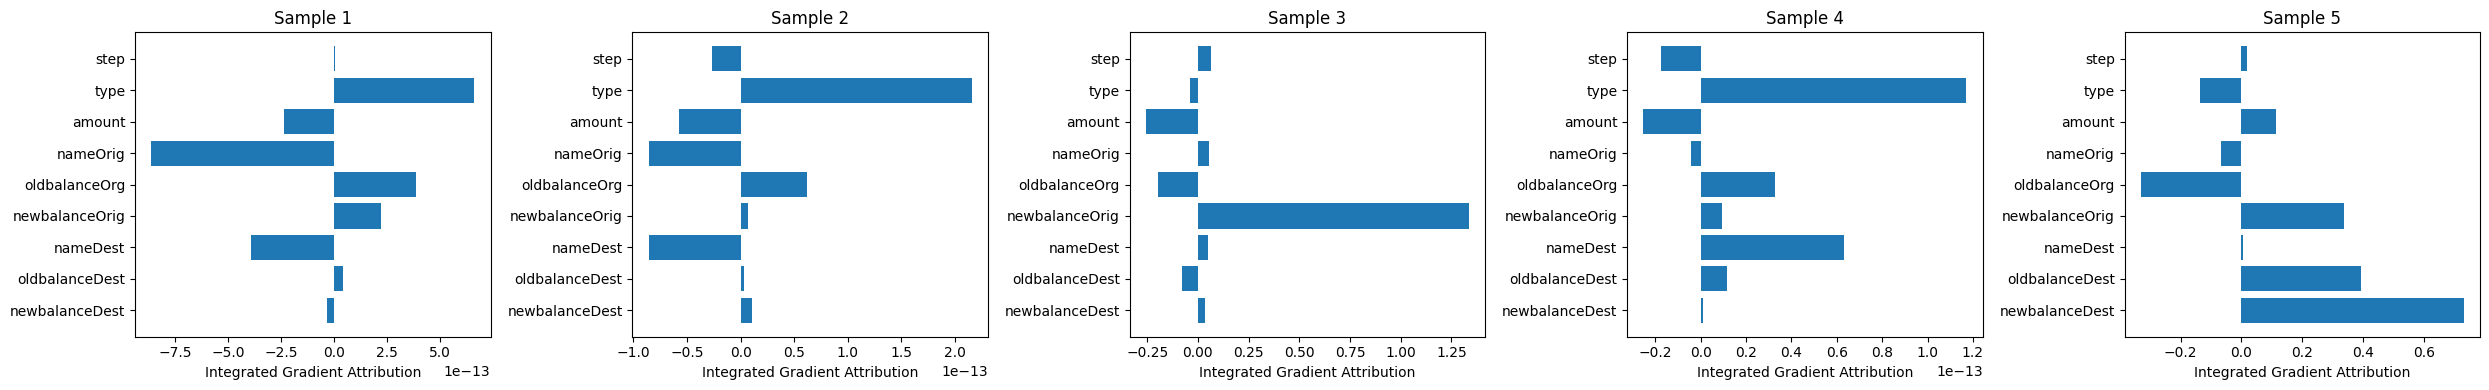

In [ ]:
num_samples = 5
fig, axes = plt.subplots(1, num_samples, figsize=(25, 4))

for idx in range(num_samples):
    sample = x_test[idx]
    baseline = np.zeros_like(sample)
    ig_attr = integrated_gradients(model, baseline, sample, target_class_index=1, m_steps=50)
    axes[idx].barh(feature_names, ig_attr)
    axes[idx].set_xlabel('Integrated Gradient Attribution')
    axes[idx].set_title(f'Sample {idx + 1}')
    axes[idx].invert_yaxis()

plt.tight_layout()
plt.show()